In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_error

import joblib

In [2]:
df = pd.read_csv('preprocessed_hourly.csv', index_col="DateTime", parse_dates=True)
df.head()

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,zone_one,zone_two,zone_three,dayofyear,hour
DateTime,,,,,,,,,,
2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.063500,0.098833,29197.974683,18026.747720,19252.048193,1,0
2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.056833,0.112500,24657.215190,16078.419453,17042.891567,1,1
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,14330.699088,15676.144578,1,2
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,13219.452887,14883.855422,1,3
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,12921.580547,14317.108433,1,4


In [3]:
df.shape

(8736, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8736 entries, 2017-01-01 00:00:00 to 2017-12-30 23:00:00
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Temperature            8736 non-null   float64
 1   Humidity               8736 non-null   float64
 2   Wind_Speed             8736 non-null   float64
 3   general_diffuse_flows  8736 non-null   float64
 4   diffuse_flows          8736 non-null   float64
 5   zone_one               8736 non-null   float64
 6   zone_two               8736 non-null   float64
 7   zone_three             8736 non-null   float64
 8   dayofyear              8736 non-null   int64  
 9   hour                   8736 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 750.8 KB


In [5]:
X = df.drop(columns=['zone_one', 'zone_two', 'zone_three']).values
y = df[['zone_one', 'zone_two', 'zone_three']].values

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (6988, 7)
Shape of y_train: (6988, 3)
Shape of X_test: (1748, 7)
Shape of y_test: (1748, 3)


In [6]:
# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [7]:
window_size = 24
# I need to create a function for making windows
def create_sequences(X, y, window_size=24):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24
# Applying the function:
X_train, y_train = create_sequences(X_train, y_train, window_size)
X_test, y_test = create_sequences(X_test, y_test, window_size)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (6964, 24, 7)
Shape of y_train: (6964, 3)
Shape of X_test: (1724, 24, 7)
Shape of y_test: (1724, 3)


In [8]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units=y_train.shape[1]))
model.summary()

d:\ML&DE\Deep_Learning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,627 (72.76 KB)

 Trainable params: 18,627 (72.76 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:

model.compile( optimizer=Adam(learning_rate= 0.001), loss='mse',)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_keras_lstm_model.keras', monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2, 
                    callbacks=[early_stopping, model_checkpoint], verbose=1)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0712 - val_loss: 0.0394
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0207 - val_loss: 0.0289
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170 - val_loss: 0.0255
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151 - val_loss: 0.0267
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0138 - val_loss: 0.0262
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125 - val_loss: 0.0328
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - val_loss: 0.0327
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - val_loss: 0.0374
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107 - val_loss: 0.0422
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - val_loss: 0.0473
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 - val_loss: 0.0608
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.

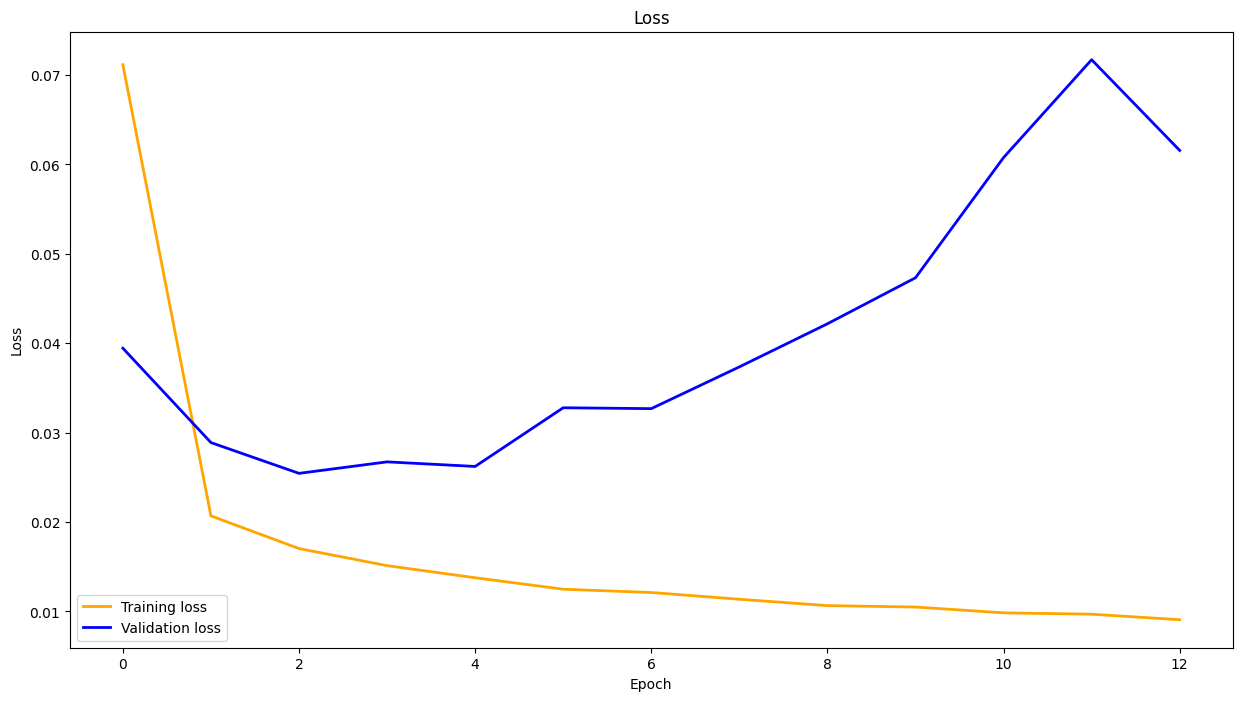

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training loss', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation loss', color='blue', linewidth=2, markersize=6)
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
